# iPhone VS Android : reddit posts classification

In [121]:
# !pip install matplotlib_venn

# libraries import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib_venn import venn2
import seaborn as sns
import joblib

#NLP libraries
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

#sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve, roc_auc_score, classification_report

style.use('seaborn-white')
sns.set_context(context='talk')
%matplotlib inline

# Problem Statement

As a data scientist at Apple, I have discussed with product development teams and found out that they are currently processing the customer feedback only from the query from Apple official websites. They feel that reports collected from forums and feedback channels are mainly about serious malfunctions containing lots of technical stuff. However, they would like to get sentiment from non-technical users for further development
i.e., 'I really love the new function in iOS 13.2.1', 'New version of Siri is fantastic!' for following purposes ...


- to see whether the users love their new function or not? 
- Which aspect need improvement?
- What do general users expect to see in the future?


To address their problem, I suggested the team to get non-technical comments from the reddit websites. Manual Collection seems to be a safe approach since I can directly go to 'iphone' subreddit and read through each single posts. Nevertheless, it is extremely labor intensive and inefficient. So in this project, I'll build a classifier to automatically distinguish iPhone posts from other kind of smartphone posts and send them to product development teams.

In the foreseeable future, I'll try to conduct a sentiment analysis on iPhone posts I got to separate positive and negative comment and hand it over to each responsible parties.

The project will compares ...

2 words to vectors converter (Vectorizers):
1. CountVectorizer
1. TfidfVectorizer

and 3 classifiers:
1. LogisticRegression
1. Naive Bayes (Multinomial variance)
1. KNearestNeighbors

The candidate model must not only yield high accuracy, but it must also be highly interpretable

# Data Collection

Data will be collected using [reddit api](https://www.reddit.com/dev/api/) with "r/android" and "r/iphone" endpoints.

Detailed data collection scripts are located in separated .py files named 'get_android.py' and 'get_iphone.py'.

Below code block is a snippet from one of the mentioned file.

In [401]:
# # Snippet from 'get_iphone.py'

# import requests
# import pandas as pd
# import numpy as np
# import random
# import time

# #Base URL
# url = 'https://www.reddit.com/r/iPhone/'
# #Get user input
# columns = input("Please specified which columns to pull [hot,new,top,rising] : ")
# url = url +columns+'.json'
# posts = []
# after = None

# #Each iteration will get roughly 25 posts from the subreddit
# for a in range(40):
#     if after == None: #for the first iteration OR after the iterator has completely gone through the subreddit
#         current_url = url
#     else:
#         current_url = url + '?after=' + after
#     print(current_url)
#     res = requests.get(current_url, headers={'User-agent': 'Pony Inc 1.0'})

#     if res.status_code != 200:
#         print('Status error', res.status_code)
#         break

#     current_dict = res.json()
#     current_posts = [p['data'] for p in current_dict['data']['children']]
#     posts.extend(current_posts)
#     after = current_dict['data']['after']

#     # Every iteration except the first round
#     if a > 0:
#         prev_posts = pd.read_csv(f'../datasets/iphone_{columns}.csv')
#         current_df = pd.DataFrame(current_posts)
#         pd.concat([prev_posts,current_df],axis=0).to_csv(f'../datasets/iphone_{columns}.csv',index=False)
#         print(f'{prev_posts.shape[0]+current_df.shape[0]} posts has been downloaded!')
        
#     # For the first round
#     else:
#         pd.DataFrame(posts).to_csv(f'../datasets/iphone_{columns}.csv', index = False)

#     # generate a random sleep duration to look more 'natural'
#     sleep_duration = random.randint(2,6)
#     print(f'Waiting for {sleep_duration} seconds')
#     time.sleep(sleep_duration)

# print(f'Successfully load iPhone_{columns} data!')


# Data Cleaning

## Iphone

In [3]:
# Read in all iPhone related posts
iphone_hot = pd.read_csv('../datasets/iphone_hot.csv')
iphone_new = pd.read_csv('../datasets/iphone_new.csv')
iphone_rising = pd.read_csv('../datasets/iphone_rising.csv')
iphone_top = pd.read_csv('../datasets/iphone_top.csv')

In [4]:
# Concatanate all DataFrame together and drop duplicated documents
iphone = pd.concat([iphone_hot,iphone_new,iphone_rising,iphone_top],axis=0,ignore_index=True)
iphone.drop_duplicates(subset=['name'],inplace=True)
iphone.shape

(876, 112)

## Android

In [5]:
# Read in all Android related posts
android_hot = pd.read_csv('../datasets/Android_hot.csv')
android_new = pd.read_csv('../datasets/Android_new.csv')
android_rising = pd.read_csv('../datasets/Android_rising.csv')
android_top = pd.read_csv('../datasets/Android_top.csv')

In [6]:
# Concatanate all DataFrame together and drop duplicated documents
android = pd.concat([android_hot,android_new,android_rising,android_top],axis=0,ignore_index=True)
android.drop_duplicates(subset=['name'],inplace=True)
android.shape

(815, 109)

## Merge dataset and select only columns containing text and our target

In [7]:
df = pd.concat([iphone, android], ignore_index=True, axis=0)
df.head()

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,created_utc,num_crossposts,media,is_video,url_overridden_by_dest,link_flair_template_id,author_cakeday,crosspost_parent_list,crosspost_parent,media_metadata
0,NaN,iphone,Welcome to the weekly stickied WSIB thread. \...,t2_6l4z3,False,NaN,0,False,Weekly What Should I Buy Thread,[],...,1.615554e+09,0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,iphone,It’s getting to that time of year again!\n\nHa...,t2_h2rle42,False,NaN,0,False,iOS 15 Wishlist Thread | What features would Y...,[],...,1.614844e+09,0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,iphone,I recently upgraded to an iPhone 12 from a XS ...,t2_12u6xf,False,NaN,0,False,3D Touch vs Haptic Touch,[],...,1.615748e+09,0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,iphone,NaN,t2_a5rx069h,False,NaN,1,False,I did this table with all released iPhones cat...,[],...,1.615687e+09,0,NaN,False,https://i.redd.it/9g8uwfs3hwm61.jpg,NaN,NaN,NaN,NaN,NaN
4,NaN,iphone,Trying to find a good budget app but most have...,t2_zooz2,False,NaN,0,False,Good Budget Apps you Don't Have To Pay For?,[],...,1.615788e+09,0,NaN,False,NaN,5664e798-6985-11e8-b750-0eaf69e27a44,NaN,NaN,NaN,NaN


In [8]:
# Do we completely merged 2 dataframe?
# If so, we should get 876 iphone and 815 android posts
df['subreddit'].value_counts()

iphone     876
Android    815
Name: subreddit, dtype: int64

In [9]:
# Feel free to add/remove any features that suit you!

X_col = ['title', 'selftext']
y_col = ['subreddit']

# saved into cleaned data files
df[X_col+y_col].to_csv('../datasets/cleaned_data.csv',index=False)

# Exploratory Data Analysis (EDA)

In [10]:
df = df[X_col+y_col]
df.head()

,title,selftext,subreddit
0,Weekly What Should I Buy Thread,Welcome to the weekly stickied WSIB thread. \...,iphone
1,iOS 15 Wishlist Thread | What features would Y...,It’s getting to that time of year again!\n\nHa...,iphone
2,3D Touch vs Haptic Touch,I recently upgraded to an iPhone 12 from a XS ...,iphone
3,I did this table with all released iPhones cat...,NaN,iphone
4,Good Budget Apps you Don't Have To Pay For?,Trying to find a good budget app but most have...,iphone


In [11]:
#preparation for EDA
def prepare_for_EDA(text):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    
    # 1. Convert all text to lowercase,
    lower = text.lower()
    
    # 2. Remove punctuation, and hyperlink
    no_html = re.sub(r'\(https?:\/\/.*[\r\n]*', '', lower)
    letters_only = re.sub("[^a-zA-Z0-9]", " ", no_html).split()
    
    # 3. remove stopwords
    stops = set(stopwords.words('english'))
    meaningful_words = [w for w in letters_only if w not in stops]
    
#     # 4. Lemmatize words
#     lem = WordNetLemmatizer()
#     lem_words = [lem.lemmatize(word) for word in meaningful_words]
    
    return(" ".join(meaningful_words))

## Length of title / text

In [12]:
#Fill na with empty string
df['selftext'] = df['selftext'].map(lambda x: "" if type(x) == float else x)

#Length of text
df['title_length'] = df['title'].str.len()
df['selftext_length'] = df['selftext'].str.len()

df.head()

,title,selftext,subreddit,title_length,selftext_length
0,Weekly What Should I Buy Thread,Welcome to the weekly stickied WSIB thread. \...,iphone,31,938
1,iOS 15 Wishlist Thread | What features would Y...,It’s getting to that time of year again!\n\nHa...,iphone,71,142
2,3D Touch vs Haptic Touch,I recently upgraded to an iPhone 12 from a XS ...,iphone,24,251
3,I did this table with all released iPhones cat...,,iphone,93,0
4,Good Budget Apps you Don't Have To Pay For?,Trying to find a good budget app but most have...,iphone,43,135


In [13]:
df.head()

,title,selftext,subreddit,title_length,selftext_length
0,Weekly What Should I Buy Thread,Welcome to the weekly stickied WSIB thread. \...,iphone,31,938
1,iOS 15 Wishlist Thread | What features would Y...,It’s getting to that time of year again!\n\nHa...,iphone,71,142
2,3D Touch vs Haptic Touch,I recently upgraded to an iPhone 12 from a XS ...,iphone,24,251
3,I did this table with all released iPhones cat...,,iphone,93,0
4,Good Budget Apps you Don't Have To Pay For?,Trying to find a good budget app but most have...,iphone,43,135


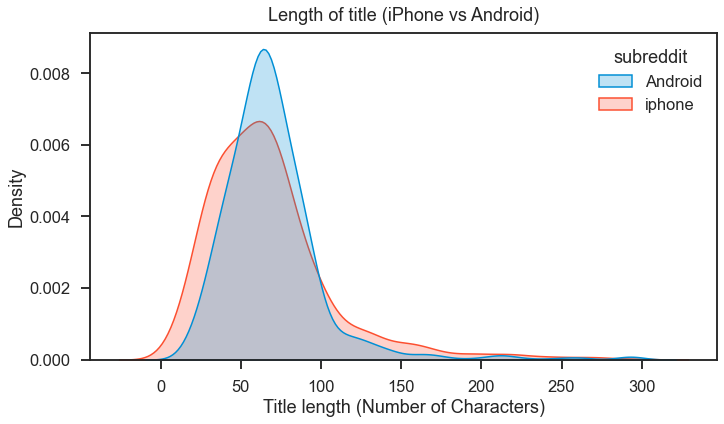

In [122]:
plt.figure(figsize=(10,6))
t = sns.kdeplot(x='title_length',hue='subreddit',fill=True,data=df)
t.set_title('Length of title (iPhone vs Android)',y = 1.02)
t.set_xlabel('Title length (Number of Characters)');

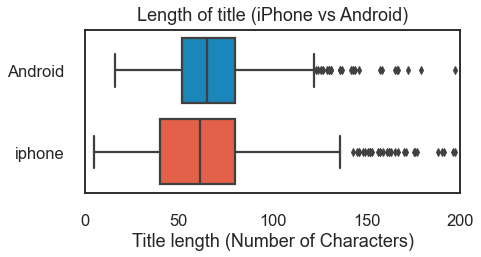

In [408]:
plt.figure(figsize=(6,3))
g = sns.boxplot(x='title_length',y='subreddit',data=df)
g.set_xlim(0,200)
g.set_ylabel('')
g.set_title('Length of title (iPhone vs Android)',y = 1.02)
g.set_xlabel('Title length (Number of Characters)');

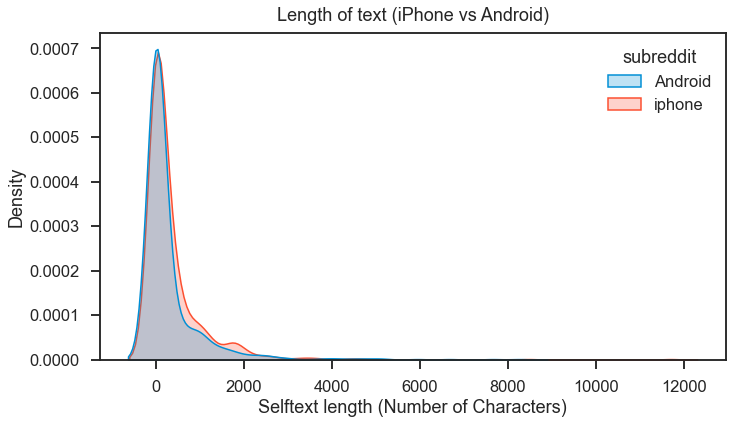

In [124]:
plt.figure(figsize=(10,6))
g = sns.kdeplot(x='selftext_length',hue='subreddit',fill=True,data=df)
g.set_title('Length of text (iPhone vs Android)',y = 1.02)
g.set_xlabel('Selftext length (Number of Characters)');

Observation:
1. Length of the title do not add much information to distinguish between iPhone and Android posts
1. Selftext length of both categories also are nearly the same, so it cannot serve as a good predictor 

## Top words

### iPhone

In [18]:
#Select only iPhone
df_iphone = df[df['subreddit'] == 'iphone']

#Combine title and text and apply preliminary cleaning
df_iphone['sum_text'] = df_iphone['title'] + df_iphone['selftext']
df_iphone['sum_text'] = df_iphone['sum_text'].apply(prepare_for_EDA)


#Vectorize the text
vec_iphone = CountVectorizer()
vec_iphone.fit(df_iphone['sum_text'])

#Create a DataFrame sorted by word frequency
top_iphone = pd.DataFrame(vec_iphone.transform(df_iphone['sum_text']).toarray(
), columns=vec_iphone.get_feature_names()).T.sum(axis=1).sort_values(ascending=False)

<ipython-input-18-719c110d5cbe>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_iphone['sum_text'] = df_iphone['title'] + df_iphone['selftext']
<ipython-input-18-719c110d5cbe>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_iphone['sum_text'] = df_iphone['sum_text'].apply(prepare_for_EDA)


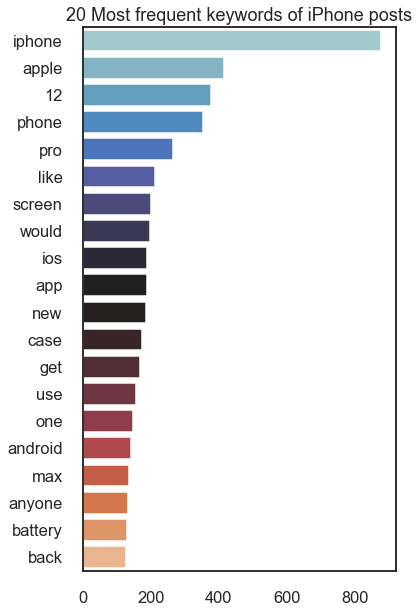

In [411]:
plt.figure(figsize=(5,10))
g = sns.barplot(x = top_iphone.values[:20], y = top_iphone.index[:20],palette='icefire')
g.set_title('20 Most frequent keywords of iPhone posts');

Obviously, the most frequent word in iPhone corpus is 'iphone' itself, followed by apple and different iphone models such as '12', 'pro', 'max'

### Android

In [20]:
#Select only android
df_android = df[df['subreddit'] == 'Android']

#Combine title and text and apply preliminary cleaning
df_android['sum_text'] = df_android['title'] + df_android['selftext']
df_android['sum_text'] = df_android['sum_text'].apply(prepare_for_EDA)


#Vectorize the text
vec_android = CountVectorizer()
vec_android.fit(df_android['sum_text'])

#Create a DataFrame sorted by word frequency
top_android = pd.DataFrame(vec_android.transform(df_android['sum_text']).toarray(
), columns=vec_android.get_feature_names()).T.sum(axis=1).sort_values(ascending=False)

<ipython-input-20-7f0c467efa2f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_android['sum_text'] = df_android['title'] + df_android['selftext']
<ipython-input-20-7f0c467efa2f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_android['sum_text'] = df_android['sum_text'].apply(prepare_for_EDA)


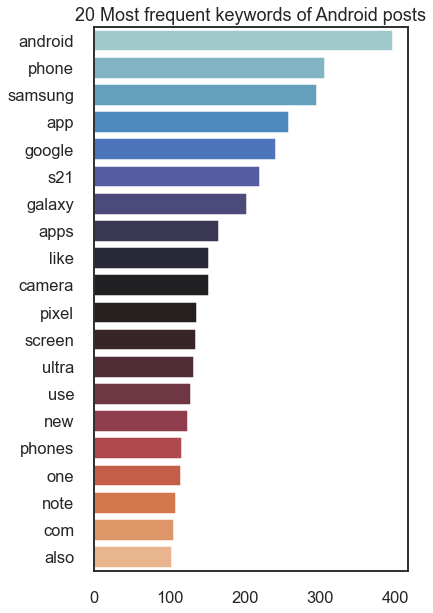

In [412]:
plt.figure(figsize=(5,10))
g = sns.barplot(x = top_android.values[:20], y = top_android.index[:20],palette='icefire')
g.set_title('20 Most frequent keywords of Android posts');

The same fashion have also been observed for android phone. The most frequent word in Android corpus is 'Android' itself, followed by different smartphone manufacturers such as 'Samsung', 'Google' and their flagship model like 'Galaxy', 'Note', 'Pixel'

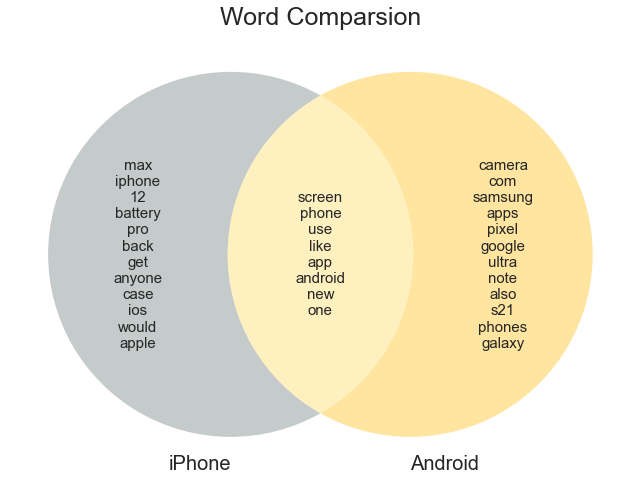

In [128]:
#Venn diagram display overlapping region of both category
plt.figure(figsize=(10, 10))
plt.title('Word Comparsion', fontsize=25)

set_iphone = set(top_iphone.index[:20])
set_android = set(top_android.index[:20])

venn = venn2([set_iphone, set_android], set_labels=['iPhone', 'Android'], set_colors=['#6e7c7c','#ffbe0f'])

venn.get_label_by_id('100').set_text(
    '\n'.join(map(str, set_iphone-set_android)))
venn.get_label_by_id('110').set_text(
    '\n'.join(map(str, set_iphone & set_android)))
venn.get_label_by_id('010').set_text(
    '\n'.join(map(str, set_android-set_iphone)))

venn.get_label_by_id('A').set_size(20)
venn.get_label_by_id('B').set_size(20)
venn.get_label_by_id('100').set_size(15)
venn.get_label_by_id('110').set_size(15)
venn.get_label_by_id('010').set_size(15)

Some of the common words that are being said in both subreddit are "android, phone, screen, app, new, one, like"

It can be inferred that people in both subreddit occasionally compared their phone with the competitors!

# Preprocessing

In [23]:
#Reshufle the dataframe
df = df.sample(frac=1,random_state=42).reset_index(drop=True)
df.head()

,title,selftext,subreddit,title_length,selftext_length
0,Meizu 18 and 18 Pro are official with Snapdrag...,,Android,98,0
1,"iQOO 7 debuts with Snapdragon 888, 120W chargi...",,Android,142,0
2,Galaxy S21 Ultra's 100x camera zoom is pointle...,,Android,71,0
3,YouTube TV is adding offline downloads and 4K ...,,Android,55,0
4,Galaxy S21 price cut all but confirmed ahead o...,,Android,54,0
...,...,...,...,...,...
1686,Saturday APPreciation (Feb 20 2021) - Your wee...,Note 1. [Check out our apps wiki](https://www....,Android,84,988
1687,"South China Morning Post: ""From phones to game...",,Android,98,0
1688,iPhone 12 Mini Review,,iphone,21,0
1689,Samsung Galaxy S21 Teardown and Repair Assessm...,,Android,73,0


In [24]:
#Define X and y
X = df['title'] + df['selftext']

#Map 'iphone' as 1 and 'Android' as 0
y = df['subreddit'].map({'iphone': 1, 'Android':0})

In [428]:
def prepare(text):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    
    # 1. Convert all text to lowercase,
    lower = text.lower()
    
    # 2. Remove punctuation, and hyperlink
    no_html = re.sub(r'\(https?:\/\/.*[\r\n]*', '', lower)
    letters_only = re.sub("[^a-zA-Z0-9]", " ", no_html).split()
    
    # 3. remove possible target leakage
    iphone_word = ['iphone','ios','apple']
    android_word = ['android','asus','blackberry','htc','huawei','lenovo','lg','meizu','motorola','samsung','nokia','zte','oneplus','oppo','realme','xiaomi','sony','vivo']
    useful_words = [w for w in letters_only if w not in (iphone_word+android_word)]
    
    # 4. stem or lemmatize each word of the text,
#     p_stemmer = PorterStemmer()
#     slemmed_words = [p_stemmer.stem(w) for w in useful_words]
    
    lem = WordNetLemmatizer()
    slemmed_words = [lem.lemmatize(word) for word in useful_words]
    
    # 5. remove stopwords
    stops = set(stopwords.words('english'))
    meaningful_words = [w for w in slemmed_words if w not in stops]
    

    
    return(" ".join(meaningful_words))

In [26]:
#Preprocessing our dataset
X = [prepare(text) for text in X]

# Modelling

In [28]:
# train and test set split with test size = 20% of the total dataset
# to ensure that we'll have nearly identical class distribution in both training and testing set, I then set stratify = y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [29]:
#Class distribution in the training set
y_train.value_counts(normalize=True)

1    0.517751
0    0.482249
Name: subreddit, dtype: float64

In [30]:
#Class distribution in the testing set
y_test.value_counts(normalize=True)

1    0.519174
0    0.480826
Name: subreddit, dtype: float64

- We should not have any unbalanced class problem; therefore, I'll train the model without setting 'class_weight' to penalize the majority class.
- Class distribution in both training and testing set are nearly identical.

In [31]:
cv = CountVectorizer()
cv.fit(X_train)

CountVectorizer()

In [32]:
len(cv.get_feature_names())

6624

### Logistic Regression

#### Count Vectorizer

In [33]:
# LR + CountVec

pipe_lr_cvec = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

pipe_lr_params = {
    'cvec__max_features': np.arange(2600,3201,100),
    'cvec__min_df': [2,3],
    'cvec__max_df': [0.70,0.75,0.80],
    'cvec__ngram_range': [(1,2)],
    'lr__C' : np.logspace(-2,0,10)

}

grid_lr_cvec = GridSearchCV(pipe_lr_cvec, param_grid=pipe_lr_params, cv=5)
grid_lr_cvec.fit(X_train,y_train)
print(f"Accuracy on the training set = {grid_lr_cvec.score(X_train,y_train)}")
print(f"Accuracy on the test set = {grid_lr_cvec.score(X_test,y_test)}")

#Save the model to pkl file
joblib.dump(grid_lr_cvec.best_estimator_, '../models/lr_cvec.pkl') 

Accuracy on the training set = 0.9866863905325444
Accuracy on the test set = 0.8436578171091446


['../models/lr_cvec.pkl']

In [34]:
grid_lr_cvec.best_estimator_

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.7, max_features=3200, min_df=2,
                                 ngram_range=(1, 2))),
                ('lr', LogisticRegression(C=0.5994842503189409))])

#### TfidfVectorizer

In [35]:
# LR + TfidfVec

pipe_lr_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

pipe_lr_params = {
    'tvec__max_features': np.arange(2600,3401,100),
    'tvec__min_df': [2,3],
    'tvec__max_df': [0.70,0.75,0.80],
    'tvec__ngram_range': [(1,2)],
    'lr__C' : np.logspace(-2,0,10)

}

grid_lr_tvec = GridSearchCV(pipe_lr_tvec, param_grid=pipe_lr_params, cv=5)
grid_lr_tvec.fit(X_train,y_train)
print(f"Accuracy on the training set = {grid_lr_tvec.score(X_train,y_train)}")
print(f"Accuracy on the test set = {grid_lr_tvec.score(X_test,y_test)}")

#Save the model to pkl file
joblib.dump(grid_lr_tvec.best_estimator_, '../models/lr_tvec.pkl') 

Accuracy on the training set = 0.9563609467455622
Accuracy on the test set = 0.8613569321533924


['../models/lr_tvec.pkl']

In [36]:
grid_lr_tvec.best_estimator_

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.7, max_features=2900, min_df=2,
                                 ngram_range=(1, 2))),
                ('lr', LogisticRegression())])

### Naive Bayes

#### CountVectorizer

In [37]:
# NB + CountVec

pipe_nb_cvec = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

pipe_nb_params = {
    'cvec__max_features': np.arange(2600,3401,100),
    'cvec__min_df': [2,3],
    'cvec__max_df': [0.70,0.75,0.80],
    'cvec__ngram_range': [(1,2)],
}

grid_nb_cvec = GridSearchCV(pipe_nb_cvec, param_grid=pipe_nb_params, cv=5)
grid_nb_cvec.fit(X_train,y_train)
print(f"Accuracy on the training set = {grid_nb_cvec.score(X_train,y_train)}")
print(f"Accuracy on the test set = {grid_nb_cvec.score(X_test,y_test)}")

#Save the model to pkl file
joblib.dump(grid_nb_cvec.best_estimator_, '../models/nb_cvec.pkl') 

Accuracy on the training set = 0.8994082840236687
Accuracy on the test set = 0.855457227138643


['../models/nb_cvec.pkl']

In [38]:
grid_nb_cvec.best_estimator_

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.7, max_features=2800, min_df=3,
                                 ngram_range=(1, 2))),
                ('nb', MultinomialNB())])

#### TfidfVectorizer

In [39]:
# nb + TfidfVec

pipe_nb_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

pipe_nb_params = {
    'tvec__max_features': np.arange(2600,3401,100),
    'tvec__min_df': [2,3],
    'tvec__max_df': [0.70,0.75,0.80],
    'tvec__ngram_range': [(1,2)],

}

grid_nb_tvec = GridSearchCV(pipe_nb_tvec, param_grid=pipe_nb_params, cv=5)
grid_nb_tvec.fit(X_train,y_train)
print(f"Accuracy on the training set = {grid_nb_tvec.score(X_train,y_train)}")
print(f"Accuracy on the test set = {grid_nb_tvec.score(X_test,y_test)}")

#Save the model to pkl file
joblib.dump(grid_nb_tvec.best_estimator_, '../models/nb_tvec.pkl') 

Accuracy on the training set = 0.9304733727810651
Accuracy on the test set = 0.855457227138643


['../models/nb_tvec.pkl']

In [40]:
grid_nb_tvec.best_estimator_

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.7, max_features=2800, min_df=3,
                                 ngram_range=(1, 2))),
                ('nb', MultinomialNB())])

### KNearestNeighbor

#### CountVectorizer

In [83]:
# KNN + CountVec

pipe_knn_cvec = Pipeline([
    ('cvec', CountVectorizer()),
    ('knn', KNeighborsClassifier())
])

pipe_knn_params = {
    'cvec__max_features': np.arange(2600,3401,100),
    'cvec__min_df': [2,3],
    'cvec__max_df': [0.70,0.75,0.80],
    'cvec__ngram_range': [(1,2)],
    'knn__n_neighbors' : np.arange(5,51,5),
    'knn__weights' : ['uniform','distance']
}

grid_knn_cvec = GridSearchCV(pipe_knn_cvec, param_grid=pipe_knn_params, cv=5)
grid_knn_cvec.fit(X_train,y_train)
print(f"Accuracy on the training set = {grid_knn_cvec.score(X_train,y_train)}")
print(f"Accuracy on the test set = {grid_knn_cvec.score(X_test,y_test)}")

#Save the model to pkl file
joblib.dump(grid_knn_cvec.best_estimator_, '../models/knn_cvec.pkl') 

Accuracy on the training set = 0.9992603550295858
Accuracy on the test set = 0.7227138643067846


['../models/knn_cvec.pkl']

In [87]:
grid_knn_cvec.best_estimator_

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.7, max_features=2800, min_df=3,
                                 ngram_range=(1, 2))),
                ('knn',
                 KNeighborsClassifier(n_neighbors=40, weights='distance'))])

#### TfidfVectorizer

In [85]:
# KNN + TfidfVec

pipe_knn_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('knn', KNeighborsClassifier())
])

pipe_knn_params = {
    'tvec__max_features': np.arange(2600,3401,100),
    'tvec__min_df': [2,3],
    'tvec__max_df': [0.70,0.75,0.80],
    'tvec__ngram_range': [(1,2)],
    'knn__n_neighbors' : np.arange(5,51,5),
    'knn__weights' : ['uniform','distance']
}

grid_knn_tvec = GridSearchCV(pipe_knn_tvec, param_grid=pipe_knn_params, cv=5)
grid_knn_tvec.fit(X_train,y_train)
print(f"Accuracy on the training set = {grid_knn_tvec.score(X_train,y_train)}")
print(f"Accuracy on the test set = {grid_knn_tvec.score(X_test,y_test)}")

#Save the model to pkl file
joblib.dump(grid_knn_tvec.best_estimator_, '../models/knn_tvec.pkl') 

Accuracy on the training set = 0.9992603550295858
Accuracy on the test set = 0.8289085545722714


['../models/knn_tvec.pkl']

In [86]:
grid_knn_tvec.best_estimator_

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.7, max_features=2800, min_df=3,
                                 ngram_range=(1, 2))),
                ('knn',
                 KNeighborsClassifier(n_neighbors=35, weights='distance'))])

# Performance Evaluation

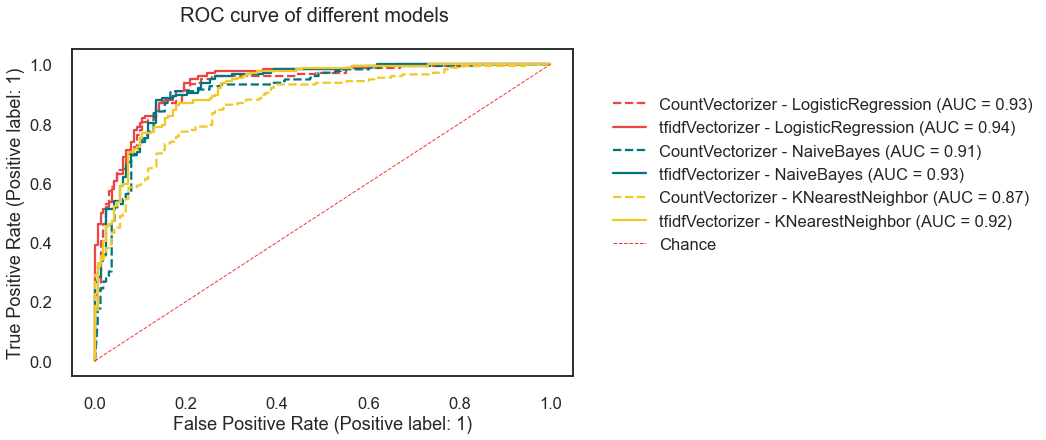

In [478]:
#Full size ROC-AUC curve

fig, ax = plt.subplots(figsize=(8,6))
fig.suptitle('ROC curve of different models',fontsize=20)

plot_roc_curve(grid_lr_cvec,X_test,y_test, ax=ax, name='CountVectorizer - LogisticRegression', linestyle='--',color='#e84545')
plot_roc_curve(grid_lr_tvec,X_test,y_test, ax=ax, name='tfidfVectorizer - LogisticRegression',color='#e84545')
plot_roc_curve(grid_nb_cvec,X_test,y_test, ax=ax, name='CountVectorizer - NaiveBayes', linestyle='--',color='#007580')
plot_roc_curve(grid_nb_tvec,X_test,y_test, ax=ax, name='tfidfVectorizer - NaiveBayes',color='#007580')
plot_roc_curve(grid_knn_cvec,X_test,y_test, ax=ax, name='CountVectorizer - KNearestNeighbor', linestyle='--',color='#f0c929')
plot_roc_curve(grid_knn_tvec,X_test,y_test, ax=ax, name='tfidfVectorizer - KNearestNeighbor',color='#f0c929')


# ax.set_xlim(0,0.5)
# ax.set_ylim(0.5,1.0)

#AUC = 0.5 line
ax.plot([0, 1], [0, 1], linestyle='--', lw=1, color='r',
        label='Chance', alpha=.8)

plt.legend(bbox_to_anchor=(1.05, 0.9));

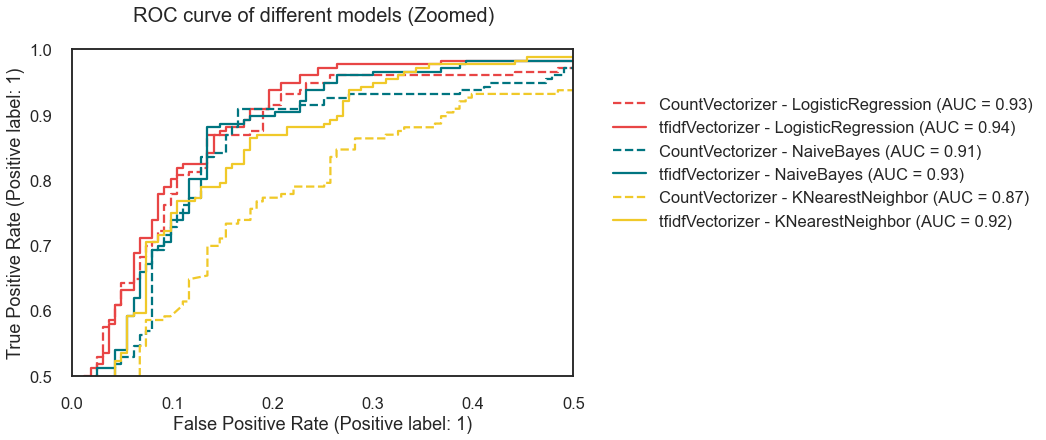

In [479]:
#Zoomed ROC-AUC curve

fig, ax = plt.subplots(figsize=(8,6))
fig.suptitle('ROC curve of different models (Zoomed)',fontsize=20)

plot_roc_curve(grid_lr_cvec,X_test,y_test, ax=ax, name='CountVectorizer - LogisticRegression', linestyle='--',color='#e84545')
plot_roc_curve(grid_lr_tvec,X_test,y_test, ax=ax, name='tfidfVectorizer - LogisticRegression',color='#e84545')
plot_roc_curve(grid_nb_cvec,X_test,y_test, ax=ax, name='CountVectorizer - NaiveBayes', linestyle='--',color='#007580')
plot_roc_curve(grid_nb_tvec,X_test,y_test, ax=ax, name='tfidfVectorizer - NaiveBayes',color='#007580')
plot_roc_curve(grid_knn_cvec,X_test,y_test, ax=ax, name='CountVectorizer - KNearestNeighbor', linestyle='--',color='#f0c929')
plot_roc_curve(grid_knn_tvec,X_test,y_test, ax=ax, name='tfidfVectorizer - KNearestNeighbor',color='#f0c929')

ax.set_xlim(0,0.5)
ax.set_ylim(0.5,1.0)

plt.legend(bbox_to_anchor=(1.05, 0.9));

Among our 6 candidate models, LogisticRegression with tfidfVecotrizer works best. Therefore it'll be used for the production.

## TfidfVectorizer + LogisticRegression as a best model

In [106]:
print(classification_report(y_test,grid_lr_tvec.predict(X_test),target_names=['Android','iPhone']))

              precision    recall  f1-score   support

     Android       0.86      0.85      0.86       163
      iPhone       0.86      0.87      0.87       176

    accuracy                           0.86       339
   macro avg       0.86      0.86      0.86       339
weighted avg       0.86      0.86      0.86       339



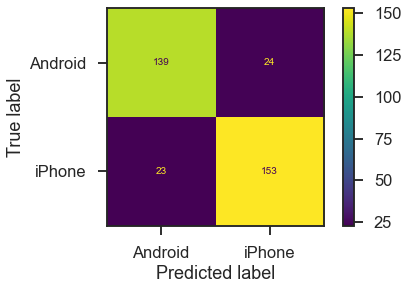

In [154]:
plot_confusion_matrix(grid_lr_tvec,X_test,y_test,display_labels=['Android','iPhone']);

Our model performs quite good on the testing set. Of the 339 documents:
1. The model correctly classified 153 of 176 iPhone posts.
1. The model efficiently sifted out 139 of 163 Android posts.
1. There are 23 iPhone posts which were incorrectly classified as Android.
1. There are 24 Android posts which were incorrectly classified as iPhone.

It's clear that our model still need further development. However, since the product development teams immediately need the model to support their work, The model inevitably be used as is.

The product dev teams are already overwhelming with tons of technical issues. Therefore I would like to raise the decision threshold, so that the model picks out the posts related to iPhone with minimal number of android posts were incorrectly picked. (We can sacrify some iPhone posts in order not to include many Android post in our result)

In [205]:
#Varying the decision thresholds, and its effect on the outcomes
for t in np.arange(0.5,0.8,0.025):
    y_pred = (grid_lr_tvec.predict_proba(X_test)[:,1] > t).astype(int)
    print(f'Confusion Matrix at decision threshold = {t}')
    tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
    print(confusion_matrix(y_test,y_pred))
    print('True Positive Rate: {}'.format(round((tp)/(tp+fn),4)))
    print('False Positive Rate: {}'.format(round((fp)/(fp+tn),4)))
    print('-----------------------------------------------')

Confusion Matrix at decision threshold = 0.5
[[139  24]
 [ 23 153]]
True Positive Rate: 0.8693
False Positive Rate: 0.1472
-----------------------------------------------
Confusion Matrix at decision threshold = 0.525
[[141  22]
 [ 30 146]]
True Positive Rate: 0.8295
False Positive Rate: 0.135
-----------------------------------------------
Confusion Matrix at decision threshold = 0.55
[[146  17]
 [ 34 142]]
True Positive Rate: 0.8068
False Positive Rate: 0.1043
-----------------------------------------------
Confusion Matrix at decision threshold = 0.5750000000000001
[[149  14]
 [ 42 134]]
True Positive Rate: 0.7614
False Positive Rate: 0.0859
-----------------------------------------------
Confusion Matrix at decision threshold = 0.6000000000000001
[[150  13]
 [ 51 125]]
True Positive Rate: 0.7102
False Positive Rate: 0.0798
-----------------------------------------------
Confusion Matrix at decision threshold = 0.6250000000000001
[[153  10]
 [ 57 119]]
True Positive Rate: 0.6761
Fal

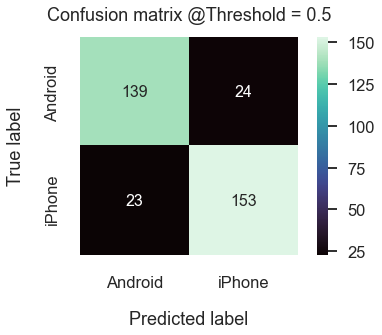

In [475]:
y_pred = (grid_lr_tvec.predict_proba(X_test)[:,1] > 0.5).astype(int)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True,
            cmap='mako', square=True, fmt='g', annot_kws={"size": 16},
           xticklabels = ['Android','iPhone'], yticklabels=['Android','iPhone'])
plt.xlabel('Predicted label',labelpad=20.0)
plt.xticks(ticks=[0.5,1.5],labels = ['Android','iPhone'])
plt.yticks(ticks=[0.3,1.3],labels = ['Android','iPhone'])
plt.ylabel('True label',labelpad=20.0);
plt.title('Confusion matrix @Threshold = 0.5',y=1.05);

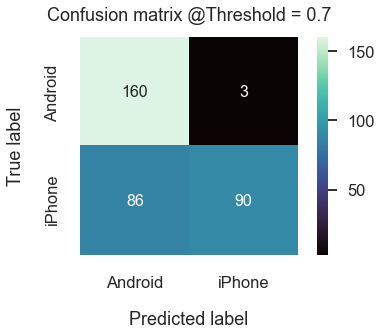

In [477]:
y_pred = (grid_lr_tvec.predict_proba(X_test)[:,1] > 0.7).astype(int)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True,
            cmap='mako', square=True, fmt='g', annot_kws={"size": 16},
           xticklabels = ['Android','iPhone'], yticklabels=['Android','iPhone'])
plt.xlabel('Predicted label',labelpad=20.0)
plt.xticks(ticks=[0.5,1.5],labels = ['Android','iPhone'])
plt.yticks(ticks=[0.3,1.3],labels = ['Android','iPhone'])
plt.ylabel('True label',labelpad=20.0);
plt.title('Confusion matrix @Threshold = 0.7',y=1.05);

The optimal threshold at 0.7 (predict a post as iPhone if the probability of being iPhone > 0.7, otherwise predict as Android) will result in half of the actual iPhone posts will be detected, while minimizing the chance of getting unintentional android post in our data.

# Interpretation

The following interpretation will be based on TfidfVectorizer + LogisticRegression model

In [358]:
#Create a dataframe containing 2,900 keywords and its coefficient
result = pd.DataFrame({'keywords' : grid_lr_tvec.best_estimator_.steps[0][1].get_feature_names(),
              'coef' : grid_lr_tvec.best_estimator_.steps[1][1].coef_[0]
             })

#take expontential transformation on the coefficient
result['exp_coef'] = result['coef'].apply(np.exp)
result.head()

,keywords,coef,exp_coef
0,10,-0.788802,0.454389
1,10 pro,-0.430633,0.650098
2,10 time,0.056508,1.058136
3,100,-0.360491,0.697334
4,101,-0.064809,0.937247


In [373]:
result.sort_values(by='exp_coef',ascending=False)[:20]

,keywords,coef,exp_coef
1381,magsafe,2.230495,9.304471
1205,iphones,2.223657,9.241061
31,14,2.140266,8.501696
428,case,1.762060,5.824421
19,12 pro,1.709826,5.527997
29,13,1.473587,4.364862
202,anyone,1.469281,4.346109
152,airpods,1.425965,4.161870
1467,mini,1.383259,3.987876
2567,time,1.298660,3.664384


In [367]:
result.sort_values(by='exp_coef',ascending=True)[:20]

,keywords,coef,exp_coef
994,google,-3.362434,0.034651
935,galaxy,-3.297753,0.036966
2114,s21,-2.651448,0.070549
1759,pixel,-2.111850,0.121014
1714,phone,-1.540613,0.214250
2635,ultra,-1.518516,0.219037
2071,review,-1.507284,0.221511
2117,s21 ultra,-1.418477,0.242082
2302,smartphone,-1.346211,0.260224
816,exynos,-1.339448,0.261990


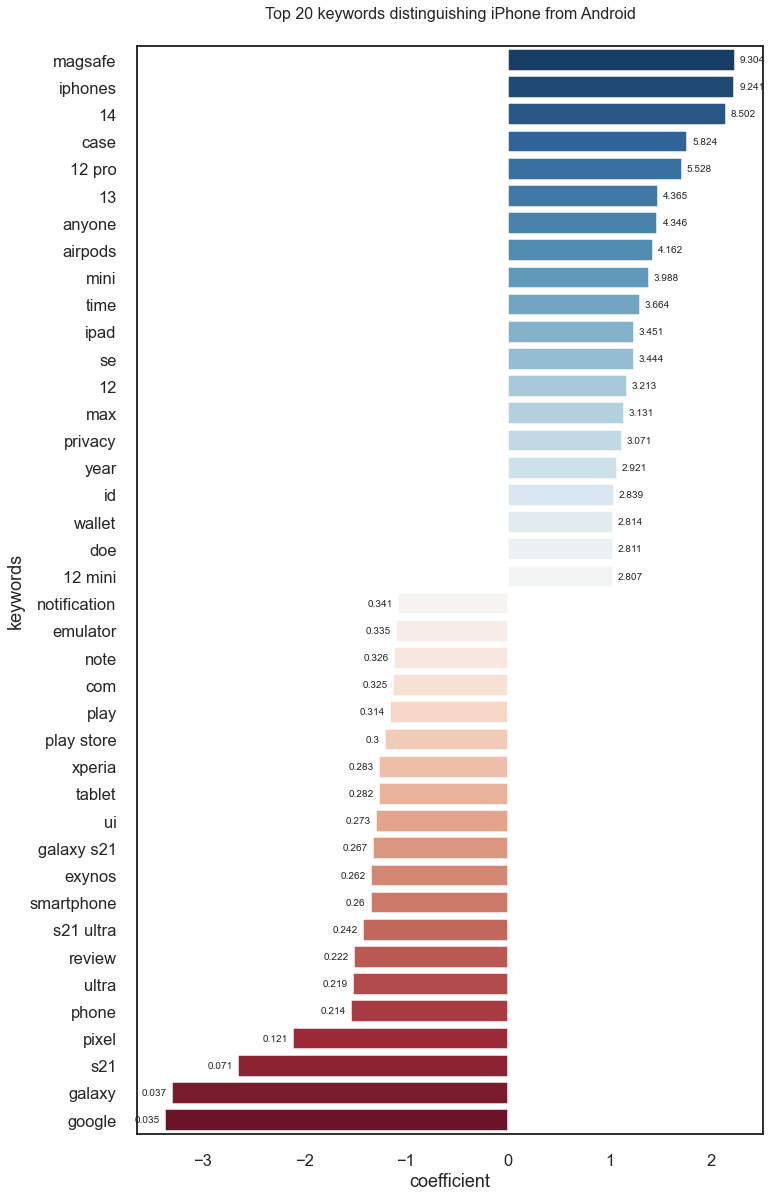

In [400]:
#Top 20 keywords for iPhone and Android
top_bot_20 = pd.concat([
    result.sort_values(by='coef', ascending=False)[:20],
    result.sort_values(by='coef', ascending=True)[:20]], axis=0)

top_bot_20 = top_bot_20.sort_values(by='coef',ascending=False)
top_bot_20

plt.figure(figsize = (10,20))
g = sns.barplot(data=top_bot_20,
            x='coef',
            y=top_bot_20.keywords,
           palette='RdBu_r')
g.set_title('Top 20 keywords distinguishing iPhone from Android',y=1.02,fontsize=16)
g.set_xlabel('coefficient');


# Annotate the graph
for i, row in enumerate(top_bot_20.iterrows()):
    if i < 20:
        g.text(y=i, x=row[1][1]+0.05, s=round(row[1][2],3), ha='left', va='center')
    else:
        g.text(y=i, x=row[1][1]-0.05, s=round(row[1][2],3), ha='right', va='center')

- As discovered in the Exploratory Data Analysis (EDA) section, a post containing keywords like "12", "case", "pro", "max", "anyone" are very likely to be an iPhone post since these word are overlapped with the most frequent words.
- In addition to the words listed above, some specific keywords indicating iPhone posts are "magsafe", "airpods", "mini", "id"
- For android posts, the keywords indicating charateristic of android such as the model (galaxy, s21, pixel, xperia ...) are the most reliable predictors used to distinguish its from iPhone posts


# Error Analysis

In [236]:
#make prediction
y_pred = grid_lr_tvec.predict(X_test)

#concat prediction with its X and actual label
compare = pd.concat([pd.Series(X_test), #Convert X_test (list) into pandas series
           y_test.reset_index(drop=True), 
           pd.Series(y_pred)], #put the prediction in pandas series
          ignore_index=True,axis=1)

compare.columns = ['Text','Actual','Predict']
compare.head()

,Text,Actual,Predict
0,pixel 2 unlimited google photo storage end today,0,0
1,tpu case bundled phone neat case dark transpar...,0,1
2,11 app suggestion feature quietly nudge user t...,0,1
3,oc camera comp s21 ultra v pixel 3a xl david v...,0,0
4,preparing partner 14 policy update,1,1


In [240]:
#False Positive
false_positive = compare[(compare['Actual'] == 0) & (compare['Predict'] == 1)]

In [247]:
false_positive['Text'].str.len().sort_values()

11       13
304      16
213      30
101      35
45       37
338      41
309      42
146      45
57       46
197      46
180      49
123      50
165      50
143      57
315      58
320      64
71       99
1       101
263     407
31      526
35      576
265     735
110     757
2      1454
Name: Text, dtype: int64

Over a half of the false positive(s) is a post with title only! Therefore, to improve the model peformance, it should includes only the post containing both title and selftext (content). Because even if we correctly predict its category, we will not get much information to feed in our sentiment analysis algorithm in subsequence steps (Of course in the future!)

In [326]:
def amb_count(input_str):
    #Ambiguous keywords
    amb = (set_iphone) & (set_android) #Set of most freqeunt word in Android and iPhone in our EDA step
    amb_list = list(amb)
    count = 0
    for word in amb_list:
        if input_str.find(word) > 0:
            count += 1
            
    return count

In [330]:
false_positive['count_amb'] = false_positive['Text'].apply(amb_count)
false_positive

<ipython-input-330-6811af161e7c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_positive['count_amb'] = false_positive['Text'].apply(amb_count)


,Text,Actual,Predict,count_amb
1,tpu case bundled phone neat case dark transpar...,0,1,2
2,11 app suggestion feature quietly nudge user t...,0,1,6
11,9 behind lens,0,1,0
31,scared future phone company getting le feature...,0,1,5
35,peel remote phone suggest block peel remote ap...,0,1,4
45,announces standless wireless charging,0,1,0
57,discontinued software support least four phone,0,1,2
71,got haptic feedback gmailit present swipe mail...,0,1,0
101,underappreciated keyboard advantage,0,1,1
110,kind shocked good 150 phone 6t died unfortunat...,0,1,5


Majority of the false positives contains at least 1 ambigous keywords (words that appear in both iPhone and Android posts)

# Conclusion

Thanks to the data pulled from reddit API, we discovered the preliminary insight since our Exploratory Data Analysis section that post containing comment about two giant smartphone operating systems (and also major manufacturers) have their own characteristics such as ...

- Obviously, the most frequent word in iPhone corpus is 'iphone' itself, followed by apple and different iphone models such as '12', 'pro', 'max'
- The same fashion have also been observed for android phone. The most frequent word in Android corpus is 'Android' itself, followed by different smartphone manufacturers such as 'Samsung', 'Google' and their flagship model like 'Galaxy', 'Note', 'Pixel'

It's hard to detect whether the post is about iPhone or Android by its simple features such as text length and title length. However, after develop and comparing several models, we can build a classifier with relatively high accuracy. The best among 6 models is the model with **TfidfVectorizer with LogisticRegression** in which it achieved 86% accuracy on the testing set.

After iterating with different decision threshold, the optimal value for our production is 0.7. This threshold allow the model to filter out iPhone related posts with minimal number of android posts leaked in. Therefore allow our product development team to further work with the data with minimal difficulty. The output of the model (Cleaned dataset containing mostly iPhone related post) can be feed into a sentiment analysis algorithm to analyze the user feedback accordingly.

## Further improvement ideas

1. Take only the posts with selftext (context) into consideration
1. Remove ambiguous keywords and re-train the model

# Reference

[Idea for Venn diagram](https://github.com/cheekeet86/project_3/blob/master/code/project_3.ipynb)